# Colegio de Postgraduados Campus Montecillo 

### Posgrado en Socioeconomía, Estadística e Informática

### <b>Cómputo Aplicado</b>

Entrenamiento para clasificación de enfermedades en frutos de aguacate utilizando el Algoritmo de <i>Random Forest</i>.
Para este entrenamiento se utilizaron las imágenes obtenidas por submuestreo de 30 x 30.

<b>Paso 1</b>: Importar las librerías necesarias. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

<b>Paso 2</b>: Definir la ruta de trabajo. 

In [2]:
ruta = "/Users/campos/Documents/COA 690/Entrenamientos Jupyter/Conjunto de datos/"
os.chdir(ruta)

<b>Paso 3</b>: Leer el conjunto de datos 

In [3]:
datos = pd.read_csv("BD135 ClssInv.csv")
datos.head()

,H,S,V,y
0,78,42,73,0
1,80,46,73,0
2,78,42,77,0
3,80,43,78,0
4,80,45,75,0


Tomando la columna <i>y</i>; las clases quedan de la siguiente forma: 0 para frutos sanos, 1 para frutos con roña y 2 para frutos con antracnosis. 

<b>Paso 4</b>: Extraer las observaciones y sus etiquetas.

In [4]:
X = datos.iloc[:, :3].values
X_s = X.shape
y = datos.iloc[:, 3].values
y_s = y.shape

print("El total de las observaciones para las tripletas HSV son :", X_s)
print("El total de las etiquetas para cada observación son: ", y_s[0])

El total de las observaciones para las tripletas HSV son : (39678, 3)
El total de las etiquetas para cada observación son:  39678


Se probará la partición <b>80:20</b>; es decir, que el $80 \%$ de los datos serán utilizados para el entrenamiento y validación; y el $20 \%$ restante será para la prueba del modelo.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

<b>Paso 5</b>: Se llama al modelo de <i>Random Forest</i>, donde se utilizarán los hiperparámetros por defecto.

In [6]:
rfc = RandomForestClassifier(random_state = 1)

<b>Paso 6</b>: Optimización de mejores hiperparámetros.

Se le conoce como búsqueda por retícula, o <i>grid search</i>, al método que consiste en definir intervalos de hiperparámetros, y el modelo realizará todas las combinaciones posibles para determinar los mejores que se ajusten y entreguen la precisión global (PG) más alta.

In [10]:
estimator_range = [100, 200, 300, 1000]
max_depth_range = [4, 6, 8]

In [11]:
param_grid = [{'n_estimators': estimator_range,
               'max_features': [ 'sqrt'],
               'max_depth': max_depth_range,
               'criterion': ['gini', 'entropy']}]

In [12]:
gs = GridSearchCV(estimator = rfc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  n_jobs = -1,
                  refit = True)

Validación cruzada

Este consiste en subdividir el conjunto de entrenamiento en grupos definidos por el usuario ($k$), en donde un subgrupo servirá como una muestra de validación para que el modelo optimice los hiperparámetros. Este es un proceso iterativo, donde cada $k$ pasará a ser un subgrupo de validación que se evaluará con los restantes.

In [13]:
kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    rfc.fit(X_train[train], y_train[train])
    score = rfc.score(X_train[test], y_train[test])
    scores.append(score)
    print("Partición: %2d, Class dist.: %s, Acc: %.5f" % (k+1, np.bincount(
        y_train[train]), score))

Partición:  1, Class dist.: [12777  9661  6129], Acc: 0.79244
Partición:  2, Class dist.: [12777  9660  6130], Acc: 0.78488
Partición:  3, Class dist.: [12778  9660  6130], Acc: 0.79395
Partición:  4, Class dist.: [12778  9660  6130], Acc: 0.78418
Partición:  5, Class dist.: [12778  9660  6130], Acc: 0.77788
Partición:  6, Class dist.: [12777  9661  6130], Acc: 0.78702
Partición:  7, Class dist.: [12777  9661  6130], Acc: 0.78765
Partición:  8, Class dist.: [12777  9661  6130], Acc: 0.78796
Partición:  9, Class dist.: [12777  9661  6130], Acc: 0.78796
Partición: 10, Class dist.: [12777  9661  6130], Acc: 0.79868


Para este caso, estos valores pertenecen al modelo RF con los hiperparámetros por defecto, a continuación se obtendrán los mejores hiperparámetros. 

In [14]:
gs = gs.fit(X_train, y_train)
gs.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 200}

<b>Paso 7</b>: Con base a esos mejores hiperparámetros, se realiza un nuevo entrenamiento, donde se definen esos valores en el modelo. 

In [7]:
pipe_rfc = make_pipeline(StandardScaler(),
                         RandomForestClassifier(criterion = 'gini',
                                                max_depth = 8,
                                                max_features = 'sqrt',
                                                n_estimators = 200,
                                                random_state = 1))

In [16]:
kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_rfc.fit(X_train[train], y_train[train])
    score = pipe_rfc.score(X_train[test], y_train[test])
    scores.append(score)
    print("Partición: %2d, Class dist.: %s, Acc: %.5f" % (k+1, np.bincount(
        y_train[train]), score))

Partición:  1, Class dist.: [12777  9661  6129], Acc: 0.79307
Partición:  2, Class dist.: [12777  9660  6130], Acc: 0.78772
Partición:  3, Class dist.: [12778  9660  6130], Acc: 0.80057
Partición:  4, Class dist.: [12778  9660  6130], Acc: 0.78418
Partición:  5, Class dist.: [12778  9660  6130], Acc: 0.78418
Partición:  6, Class dist.: [12777  9661  6130], Acc: 0.78891
Partición:  7, Class dist.: [12777  9661  6130], Acc: 0.78639
Partición:  8, Class dist.: [12777  9661  6130], Acc: 0.79143
Partición:  9, Class dist.: [12777  9661  6130], Acc: 0.79017
Partición: 10, Class dist.: [12777  9661  6130], Acc: 0.79868


In [17]:
pipe_rfc.score(X_train, y_train)

0.8008317056266145

<b>Paso 7</b>: Evaluar el modelo con los datos de prueba ($20 \%$) 

In [18]:
y_train_pred = pipe_rfc.predict(X_train)
y_test_pred = pipe_rfc.predict(X_test)
y_proba = pipe_rfc.predict_proba(X_test) # Este es utilizado para crear las curvas ROC - AUC

<b>Paso 8</b>: Obtener matriz de confusión y curvas ROC - AUC para los datos de prueba 

In [20]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.88      0.81      3550
           1       0.92      0.79      0.85      2683
           2       0.73      0.64      0.68      1703

    accuracy                           0.80      7936
   macro avg       0.80      0.77      0.78      7936
weighted avg       0.81      0.80      0.80      7936



Como se puede observar, la matriz de confusión redondea al entero siguiente los valores de exactitud o <i>accuracy</i>. 

<b>Matriz de confusión</b>

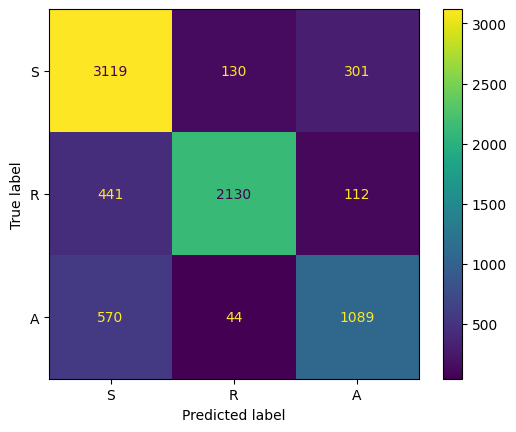

In [21]:
etiquetas = ["S", "R", "A"]
cm = confusion_matrix(y_test, y_test_pred, labels = pipe_rfc.classes_)
display = ConfusionMatrixDisplay(confusion_matrix = cm,
                                 display_labels = etiquetas)
display.plot()

Donde S corresponde a los frutos sanos; R a los frutos con roña y A a los frutos con antracnosis. 

<b>Curva ROC y AUC</b> 

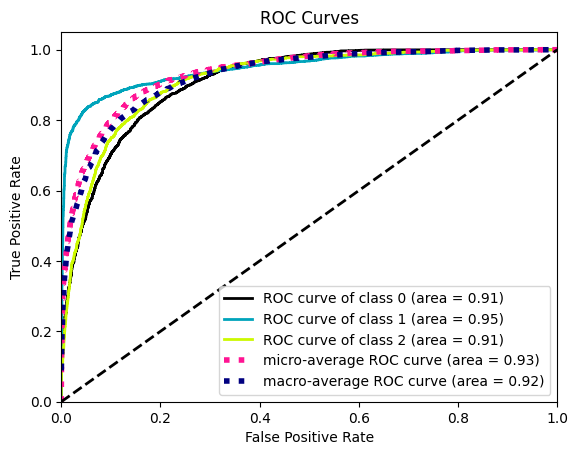

In [22]:
skplt.metrics.plot_roc(y_test, y_proba)
plt.show()

Adicionalmente, se realizó otro entrenamiento, que, para este caso, se utilizó el $100 \%$ de los datos para entrenamiento y validación, utilizando los hiperparámetros optimizados. 

In [8]:
kfold = StratifiedKFold(n_splits = 10).split(X, y)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_rfc.fit(X[train], y[train])
    score = pipe_rfc.score(X[test], y[test])
    scores.append(score)
    print("Partición: %2d, Class dist.: %s, Acc: %.5f" % (k+1, np.bincount(
        y[train]), score))

Partición:  1, Class dist.: [15972 12075  7663], Acc: 0.80696
Partición:  2, Class dist.: [15972 12075  7663], Acc: 0.77293
Partición:  3, Class dist.: [15972 12075  7663], Acc: 0.83770
Partición:  4, Class dist.: [15972 12075  7663], Acc: 0.66885
Partición:  5, Class dist.: [15972 12076  7662], Acc: 0.58619
Partición:  6, Class dist.: [15972 12076  7662], Acc: 0.80242
Partición:  7, Class dist.: [15972 12076  7662], Acc: 0.75126
Partición:  8, Class dist.: [15973 12075  7662], Acc: 0.61593
Partición:  9, Class dist.: [15973 12075  7663], Acc: 0.76431
Partición: 10, Class dist.: [15973 12075  7663], Acc: 0.78246


In [9]:
pipe_rfc.score(X, y)

0.8005695851605423

In [10]:
y_test_pred = pipe_rfc.predict(X)
y_proba = pipe_rfc.predict_proba(X) # Este es utilizado para crear las curvas ROC - AUC

In [11]:
print(metrics.classification_report(y, y_test_pred))

              precision    recall  f1-score   support

           0       0.75      0.89      0.82     17747
           1       0.94      0.79      0.86     13417
           2       0.73      0.62      0.67      8514

    accuracy                           0.80     39678
   macro avg       0.81      0.77      0.78     39678
weighted avg       0.81      0.80      0.80     39678



<b>Como se puede observar, utilizando la partición 80:20, como el total de las observaciones, se desempeñó ligeramente mejor el modelo optimizado con el total de las observaciones para el entrenamiento y validación</b>. 

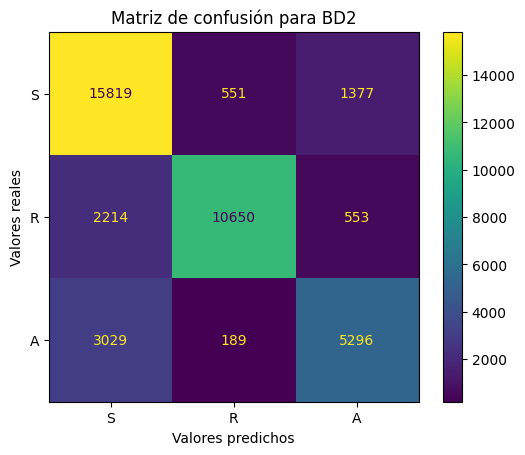

In [14]:
etiquetas = ["S", "R", "A"]
cm = confusion_matrix(y, y_test_pred, labels = pipe_rfc.classes_)
display = ConfusionMatrixDisplay(confusion_matrix = cm,
                                 display_labels = etiquetas)
display.plot()
plt.title("Matriz de confusión para BD2")
plt.xlabel("Valores predichos")
plt.ylabel("Valores reales")
plt.show()

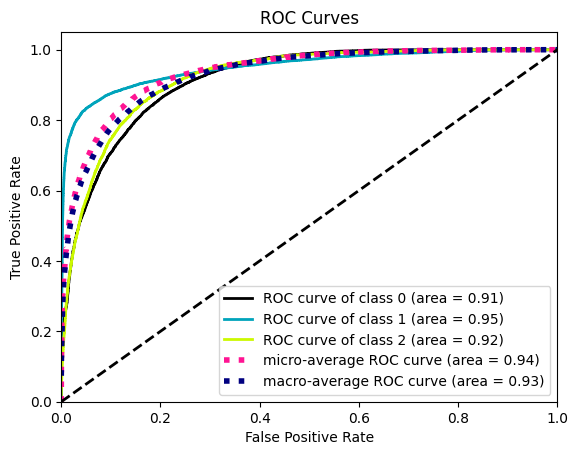

In [29]:
skplt.metrics.plot_roc(y, y_proba)
plt.show()

Existe una ligera diferencia entre las curvas, para ambos conjuntos de datos. 